# LSTM and CONVOLUTIONS for LOG-RETURN PREDICTION

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Conv1D, Cropping1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Mount Google Drive to access files
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Drive already mounted or not in Colab environment.")

# Set the seed
np.random.seed(39)
tf.random.set_seed(39)


Mounted at /content/drive


In [81]:
file_path = '/content/drive/MyDrive/EconometricsLSTM/nifty_lagged_indicator.csv'

df = pd.read_csv(file_path, parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df.head()

,Unnamed: 0,X,Date,open,high,low,close,volume,Open,High,...,macd,rsi,ulti,volatility,roc,dema,atr,cci,obv,wr
0,2,2,2017-01-03,8195.25,8219.00,1,8189.05,135579793,8210.10,8211.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117899648,NaN
1,3,3,2017-01-04,8200.80,8218.45,1,8196.35,141064842,8195.25,8219.00,...,NaN,NaN,NaN,NaN,0.001204,NaN,8218.00,NaN,253479441,NaN
2,4,4,2017-01-05,8226.65,8282.55,1,8270.50,166577106,8200.80,8218.45,...,NaN,NaN,NaN,NaN,0.000891,NaN,8217.45,NaN,394544283,NaN
3,5,5,2017-01-06,8283.00,8306.50,1,8248.20,150211914,8226.65,8282.55,...,NaN,NaN,NaN,NaN,0.009006,NaN,8281.55,NaN,561121389,NaN
4,6,6,2017-01-09,8259.10,8260.30,1,8234.55,106756707,8283.00,8306.50,...,NaN,NaN,NaN,NaN,-0.002700,NaN,8305.50,NaN,410909475,NaN


# 1-STEP AHEAD
However we do not use a rollig window: we do not retrain the model after each prediction due to computational time

In [82]:
# Compute daily log-return
# df['target'] = np.log(df['close'] / df['open'])

# OR if log(close/close):
df['target'] = np.log(df['close'] / df['Close'])

df['Log_return'] = df['target'].shift(1)

print(df.head())

   Unnamed: 0  X       Date     open     high  low    close     volume  \
0           2  2 2017-01-03  8195.25  8219.00    1  8189.05  135579793   
1           3  3 2017-01-04  8200.80  8218.45    1  8196.35  141064842   
2           4  4 2017-01-05  8226.65  8282.55    1  8270.50  166577106   
3           5  5 2017-01-06  8283.00  8306.50    1  8248.20  150211914   
4           6  6 2017-01-09  8259.10  8260.30    1  8234.55  106756707   

      Open     High  ...  ulti  volatility       roc  dema      atr  cci  \
0  8210.10  8211.70  ...   NaN         NaN       NaN   NaN      NaN  NaN   
1  8195.25  8219.00  ...   NaN         NaN  0.001204   NaN  8218.00  NaN   
2  8200.80  8218.45  ...   NaN         NaN  0.000891   NaN  8217.45  NaN   
3  8226.65  8282.55  ...   NaN         NaN  0.009006   NaN  8281.55  NaN   
4  8283.00  8306.50  ...   NaN         NaN -0.002700   NaN  8305.50  NaN   

         obv  wr    target  Log_return  
0  117899648 NaN  0.001204         NaN  
1  253479441 NaN

Data spitting, scaling and sequence preparation

In [83]:
# Select the features and target
FEATURES = [
    'Log_return',     # previous day log return
    'Volume',
    'macd', 'rsi', 'ulti', 'volatility', 'roc', 'dema', 'atr', 'cci', 'obv', 'wr'
]
TARGET = 'target'

# Restrict the dataframe from the dates with no NaNs
df = df[df['Date'] >= '2017-02-13'].reset_index(drop=True)

# Keep test all 2019, train from start to end sept 2018, val last 3 months of 2019
train_end   = pd.to_datetime('2018-09-30')
val_start   = pd.to_datetime('2018-10-01')
val_end     = pd.to_datetime('2018-12-31')
test_start  = pd.to_datetime('2019-01-01')

# Hyperparameters for bulding the dataset (telescope, i.e. the len of the prediction
# output is set to 1: we focus on the single point 1-step ahead predction. Also
# stride is set to 1 so that the window moves one-at-a-time)
WINDOW    = 10  # Len of the input
STRIDE    = 1 # If 1 it predicts every day, if different the window slides of the given slide --> predicts a subset of days
TELESCOPE = 1  # How many to predict (WE FIX IT TO 1: MANY-TO-ONE OUTPUT)

# For each split, extend backwards by WINDOW days to allow full sequences (so we can alow full
# 2019 prediction, or validation on all last three months of 2018)
# The final +1 is given for purposes seen in the following loop
train_end_idx = df.index[df['Date'] <= train_end].max()+1
val_start_idx = df.index[df['Date'] >= val_start].min()+1
val_end_idx = df.index[df['Date'] <= val_end].max()+1
test_start_idx= df.index[df['Date'] >= test_start].min()+1

# Extend each split backwards by WINDOW rows
raw_train = df.iloc[: train_end_idx + 1]  # all rows up to train_end (INCLUDED)
raw_val   = df.iloc[ max(0, val_start_idx - WINDOW) : val_end_idx + 1 ]
raw_test  = df.iloc[ max(0, test_start_idx - WINDOW) : ]

print("Train slice rows:", raw_train.shape)
print("Val   slice rows:", raw_val.shape)
print("Test  slice rows:", raw_test.shape)

# Separate X/y
Xtr_df, ytr_df = raw_train[FEATURES], raw_train[[TARGET]]
Xvl_df, yvl_df = raw_val[FEATURES],   raw_val[[TARGET]]
Xte_df, yte_df = raw_test[FEATURES],  raw_test[[TARGET]]

# Min–Max scaling
x_scaler = MinMaxScaler().fit(Xtr_df)
Xtr = x_scaler.transform(Xtr_df)
Xvl = x_scaler.transform(Xvl_df)
Xte = x_scaler.transform(Xte_df)

y_scaler = MinMaxScaler().fit(ytr_df)
ytr = y_scaler.transform(ytr_df)
yvl = y_scaler.transform(yvl_df)
yte = y_scaler.transform(yte_df)

# Fuction to build the sequence
def build_sequences(X, y, dates, window=50, telescope=1, stride=1):
    Xs, ys, ds = [], [], []

    # We put -1 to keep the dim of the window correct. moreover, the dataset is
    # built so that in each row the features are the ones of the day before to predict
    # the close of the given day after: this is the reaosn why we are selecting
    # the element in start+window-1 (this is also consistent with how we defied the
    # train_end_idx, val_start_idx, ... previously)
    for start in range(0, len(X) - window - telescope+1, stride):
        Xs.append(X[start:start+window])
        ys.append(y[start+window-1:start+window+telescope-1])
        ds.append(dates[start+window-1])
    return np.array(Xs), np.array(ys), np.array(ds)


Xtr, ytr, dtr = build_sequences(Xtr, ytr, raw_train['Date'].values, window = WINDOW, telescope=TELESCOPE, stride= STRIDE)
Xvl, yvl, dvl = build_sequences(Xvl, yvl, raw_val  ['Date'].values, window = WINDOW, telescope=TELESCOPE, stride= STRIDE)
Xte, yte, dte = build_sequences(Xte, yte, raw_test ['Date'].values, window = WINDOW, telescope=TELESCOPE, stride= STRIDE)
# DATES CHECKED: CORRECT (dvl from 2018-10-01 to 2018-12-31 and dte 2019-01-01 to end with no overalapping)

print("Train preds:", len(dtr),
      "Val preds:", len(dvl),
      "Test preds:", len(dte))

Train slice rows: (404, 25)
Val   slice rows: (70, 25)
Test  slice rows: (254, 25)
Train preds: 394 Val preds: 60 Test preds: 244


Building the netural networ model + prediction

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 10, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 10, 128)        │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 10, 1)          │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_9 (Cropping1D)       │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,305 (1.66 MB)

 Trainable params: 434,305 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
25/25 - 4s - 162ms/step - loss: 0.0842 - val_loss: 0.0786 - learning_rate: 1.0000e-03
Epoch 2/200
25/25 - 0s - 13ms/step - loss: 0.0326 - val_loss: 0.0652 - learning_rate: 1.0000e-03
Epoch 3/200
25/25 - 0s - 13ms/step - loss: 0.0264 - val_loss: 0.0624 - learning_rate: 1.0000e-03
Epoch 4/200
25/25 - 0s - 17ms/step - loss: 0.0275 - val_loss: 0.0611 - learning_rate: 1.0000e-03
Epoch 5/200
25/25 - 1s - 31ms/step - loss: 0.0237 - val_loss: 0.0609 - learning_rate: 1.0000e-03
Epoch 6/200
25/25 - 1s - 31ms/step - loss: 0.0256 - val_loss: 0.0604 - learning_rate: 1.0000e-03
Epoch 7/200
25/25 - 0s - 18ms/step - loss: 0.0225 - val_loss: 0.0600 - learning_rate: 1.0000e-03
Epoch 8/200
25/25 - 0s - 18ms/step - loss: 0.0228 - val_loss: 0.0604 - learning_rate: 1.0000e-03
Epoch 9/200
25/25 - 1s - 26ms/step - loss: 0.0233 - val_loss: 0.0599 - learning_rate: 1.0000e-03
Epoch 10/200
25/25 - 1s - 25ms/step - loss: 0.0217 - val_loss: 0.0605 - learning_rate: 1.0000e-03
Epoch 11/200
25/25 - 0s - 19

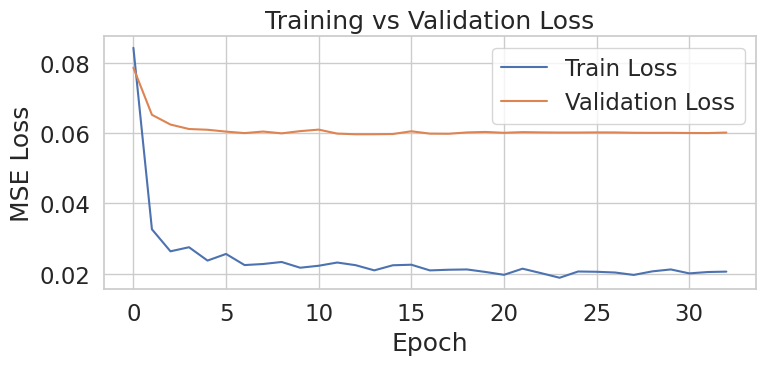

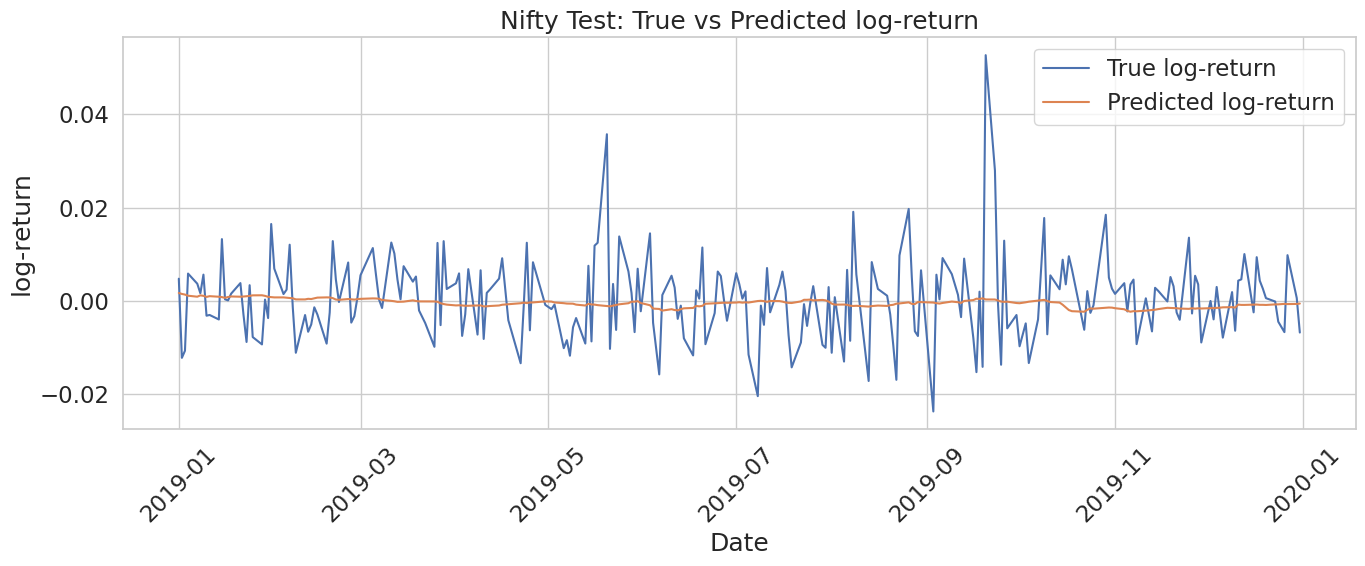

In [84]:
# Build Conv-LSTM model
def build_conv_lstm(input_shape, telescope):

    # Take the
    inp = layers.Input(shape=input_shape)
    x = layers.LSTM(128, return_sequences=True)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv1D(1, 3, padding='same')(x)         # shape: (window, 1)
    crop = WINDOW - telescope
    out = layers.Cropping1D((crop, 0))(x)              # shape: (telescope, 1)
    model = models.Model(inp, out)
    model.compile(loss='mse', optimizer='adam')
    return model

model = build_conv_lstm((WINDOW, len(FEATURES)), TELESCOPE)
model.summary()

# Train once on train+val
es = callbacks.EarlyStopping('val_loss', patience=20, restore_best_weights=True)
rl = callbacks.ReduceLROnPlateau('val_loss', patience=5, factor=0.1, min_lr=1e-5)

history = model.fit(
    Xtr, ytr,
    validation_data=(Xvl, yvl),
    epochs=200, batch_size=16,
    callbacks=[es, rl],
    verbose=2
)

# Evaluate on test
pred = model.predict(Xte).reshape(-1,)
true = yte.reshape(-1,)
# Inverse scale
pred_flat = y_scaler.inverse_transform(pred.reshape(-1,1)).flatten()
true_flat = y_scaler.inverse_transform(true.reshape(-1,1)).flatten()

print(f"Test MSE: {mean_squared_error(true_flat, pred_flat):.4f}")
print(f"Test MAE: {mean_absolute_error(true_flat, pred_flat):.4f}")

# Directional accuracy
directional_acc = np.mean((pred_flat > 0) == (true_flat  > 0))
print(f"Directional Accuracy: {100 * directional_acc:.2f}%")

# Plot training & validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()


# Plot ALL test predictions vs true with dates
results = pd.DataFrame({'Date': dte, 'True_Close': true_flat, 'Pred_Close': pred_flat})
results.set_index('Date', inplace=True)
plt.figure(figsize=(14,6))
plt.plot(results.index, results['True_Close'], label='True log-return')
plt.plot(results.index, results['Pred_Close'], label='Predicted log-return')
plt.xticks(rotation=45); plt.xlabel('Date'); plt.ylabel('log-return')
plt.title('Nifty Test: True vs Predicted log-return')
plt.legend(); plt.tight_layout(); plt.show()


# Trading Strategy 1

In [85]:
pred_change = np.abs(np.diff(pred_flat) / pred_flat[:-1])
pred_change = np.insert(pred_change, 0, 0)  # Align length

In [86]:
formatted_change = [f"{x * 100:.1f}%" for x in pred_change]
print(formatted_change)

['0.0%', '11.7%', '9.0%', '17.5%', '18.7%', '30.6%', '8.3%', '20.4%', '18.0%', '11.6%', '9.0%', '17.1%', '23.8%', '13.6%', '5.3%', '4.2%', '7.8%', '5.4%', '11.2%', '1.1%', '10.2%', '18.8%', '7.3%', '6.5%', '0.0%', '7.2%', '8.6%', '11.0%', '40.2%', '0.9%', '36.9%', '10.1%', '33.0%', '28.7%', '6.5%', '1.8%', '19.0%', '48.5%', '18.7%', '63.2%', '13.7%', '15.1%', '30.6%', '15.4%', '20.1%', '2.8%', '9.0%', '55.8%', '82.1%', '219.7%', '270.6%', '13.5%', '16.3%', '218.1%', '91.0%', '661.0%', '7.0%', '22.0%', '90.0%', '188.8%', '37.7%', '19.1%', '22.2%', '3.5%', '4.3%', '7.4%', '0.3%', '6.1%', '1.9%', '24.0%', '2.7%', '5.2%', '10.6%', '16.8%', '13.1%', '31.8%', '28.0%', '26.7%', '28.1%', '3.2%', '75.8%', '62.9%', '158.5%', '50.3%', '17.9%', '4.5%', '1.2%', '34.5%', '25.1%', '38.0%', '23.5%', '4.1%', '14.6%', '20.3%', '7.3%', '13.8%', '12.9%', '17.4%', '33.4%', '68.2%', '11.9%', '81.2%', '1599.2%', '115.4%', '79.5%', '4.8%', '20.8%', '14.6%', '10.4%', '3.3%', '12.7%', '10.2%', '5.7%', '28.8%', 

In [87]:
# Select what kind of prediction u have
type_pred = "close_close"
# type_pred = "close_open"

threshold_change = 0.1
transaction_cost = 0.0005 # 5 bps
positions = np.zeros_like(pred_flat)

# Initialize position based on first prediction
positions[0] = 1 if pred_flat[0] > 0 else (-1 if pred_flat[0] < 0 else 0)

count=0
ones =0
neg=0
for t in range(1, len(pred_flat)):
    if pred_change[t] >= threshold_change:
        count+=1

        # Update position if predicted return > 0 or < 0
        if pred_flat[t] > 0:
            ones+=1
            positions[t] = 1
        elif pred_flat[t] < 0:
            neg+=1
            positions[t] = -1
        else:
            positions[t] = 0
    else:
        # Keep previous position if change is small
        positions[t] = positions[t-1]

# Since we are consiering we are NOT in the market during the night, we need to take into account
# costs related to this (both of exiting and entering the market if I am in the market)

if type_pred == "close_open":

  prev_pos_nz = positions[:-1] != 0
  curr_pos_nz = positions[1:] != 0
  costs = np.zeros_like(positions, dtype=float)
  costs[1:] = transaction_cost * (prev_pos_nz.astype(int) + curr_pos_nz.astype(int))

  # Pay also at start
  costs[0] = transaction_cost * (positions[0] != 0).astype(int)

else:
  pos_change = np.diff(positions, prepend=0)
  costs = np.abs(pos_change).astype(float) * transaction_cost

print(count)
print(ones)
print(neg)

strategy_return = positions * true_flat-costs
cumulative_return = np.cumsum(strategy_return)

# Simple returns
simple_returns = np.exp(strategy_return) - 1

155
50
105


In [88]:
positions

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
       -1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1.,
       -1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1

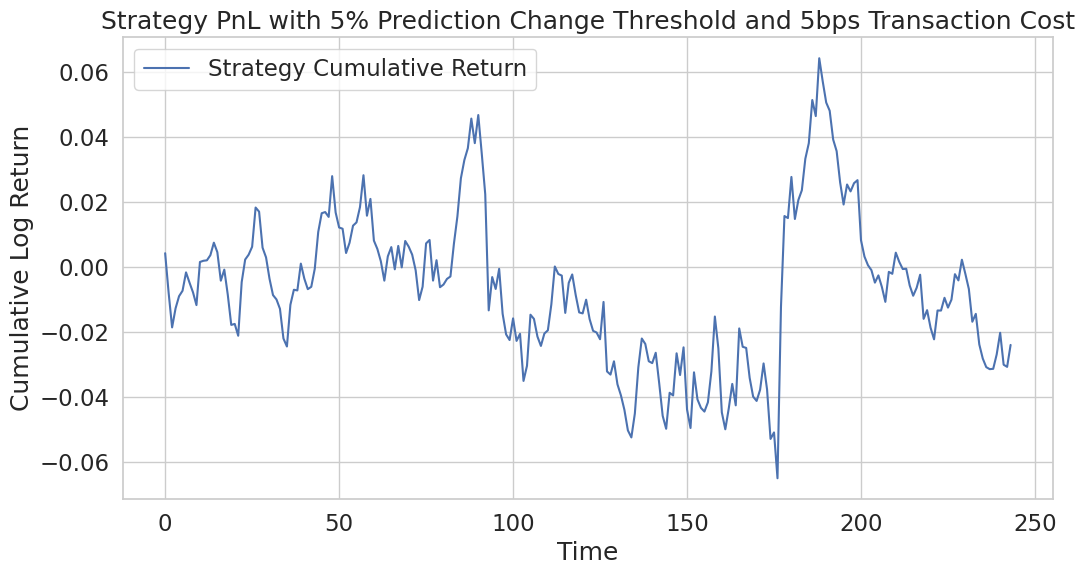

In [89]:
# Plot the cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(cumulative_return, label="Strategy Cumulative Return")
plt.title("Strategy PnL with 5% Prediction Change Threshold and 5bps Transaction Cost")
plt.xlabel("Time")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.show()

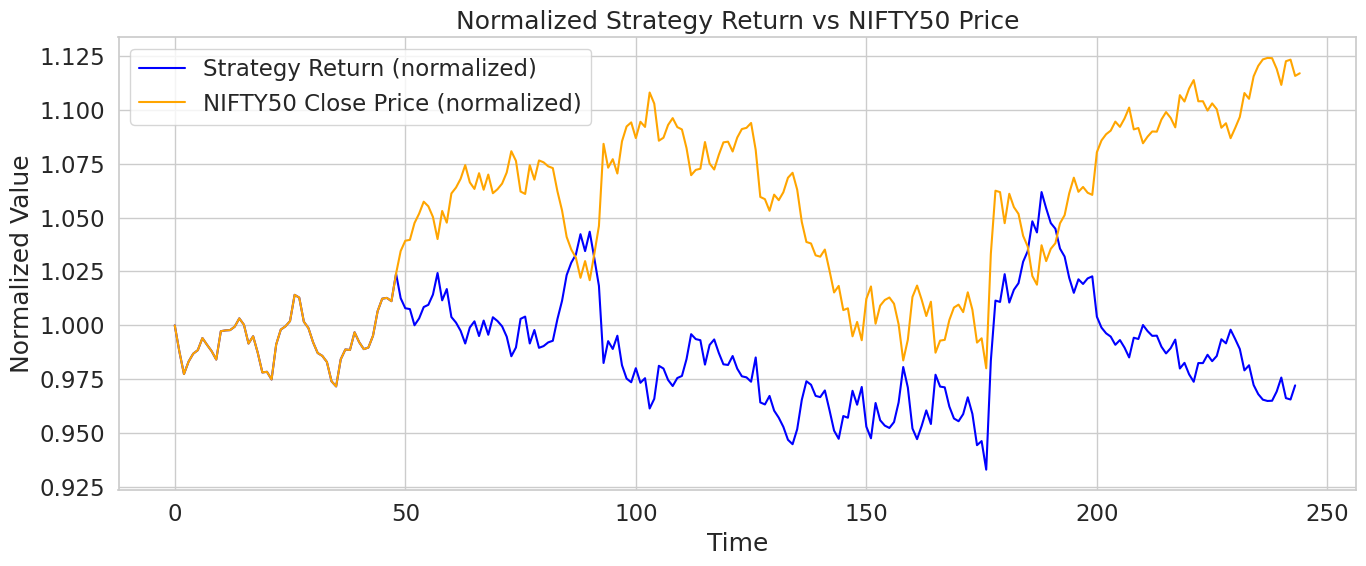

In [90]:
# Convert cumulative log return to cumulative return
cumulative_return_pct = np.exp(cumulative_return)

# Normalize both to start at 1
cumulative_return_norm = cumulative_return_pct / cumulative_return_pct[0]
df_2019 = df[df['Date'] >= '2019-01-01'].reset_index()
close_price_norm = df_2019['close'] / df_2019['close'].iloc[0]

plt.figure(figsize=(14, 6))
plt.plot(cumulative_return_norm, label="Strategy Return (normalized)", color='blue')
plt.plot(close_price_norm, label="NIFTY50 Close Price (normalized)", color='orange')
plt.title("Normalized Strategy Return vs NIFTY50 Price")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
# Metrics to evaluate the strategy
def strategy_metrics(returns, periods_per_year=252, risk_free_rate=0.0):

    r = np.asarray(returns)
    T = len(r)

    # Annualized Return
    cum_growth = np.prod(1 + r)
    ann_return = cum_growth**(periods_per_year / T) - 1

    # Annualized Sharpe Ratio
    excess = r - risk_free_rate
    sharpe = (np.mean(excess) / np.std(excess, ddof=1)) * np.sqrt(periods_per_year)

    # Maximum Drawdown
    wealth_index = np.cumprod(1 + r)
    peak = np.maximum.accumulate(wealth_index)
    drawdowns = (peak - wealth_index) / peak
    max_dd = np.max(drawdowns)

    # Sortino Ratio
    negative_returns = r[r < 0]
    downside_std = np.std(negative_returns, ddof=1) if negative_returns.size > 0 else np.nan
    sortino = (np.mean(excess) / downside_std) * np.sqrt(periods_per_year)

    return {
        'Annualized Return': ann_return,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd,
        'Sortino Ratio': sortino
    }

In [92]:
metrics = strategy_metrics(simple_returns,periods_per_year=252,risk_free_rate=0.0)

print("Annualized Return: ", f"{metrics['Annualized Return']*100:.2f}%")
print("Sharpe Ratio:       ", f"{metrics['Sharpe Ratio']:.2f}")
print("Max Drawdown:       ", f"{metrics['Max Drawdown']*100:.2f}%")
print("Sortino Ratio:      ", f"{metrics['Sortino Ratio']:.2f}")

Annualized Return:  -2.44%
Sharpe Ratio:        -0.11
Max Drawdown:        10.57%
Sortino Ratio:       -0.18


# Trading Strategy 2

In [93]:
def trading_strategy(log_return_pred, log_return_true, type_pred, transaction_cost = 0.0005, threshold = 0.0001):
    positions = np.where(log_return_pred > threshold, 1,
                 np.where(log_return_pred < -threshold, -1, 0))


    if type_pred == "close_open":
      # Pay transaction cost considering at night I am out of the market
      prev_pos_nz = positions[:-1] != 0
      curr_pos_nz = positions[1:] != 0

      costs = np.zeros_like(positions, dtype=float)

      costs[1:] = transaction_cost * (prev_pos_nz.astype(int) + curr_pos_nz.astype(int))

      # Pay also at start
      costs[0] = transaction_cost * (positions[0] != 0).astype(int)

    else:

      pos_change = np.diff(positions, prepend=0)
      costs = np.abs(pos_change).astype(float) * transaction_cost


    strategy_return = (positions * log_return_true) - costs
    cumulative_return = np.cumsum(strategy_return)

    return pd.DataFrame({
        'Position': positions,
        'Strategy Return': strategy_return,
        'Cumulative Return': cumulative_return,
        'Costs': costs
    })

In [94]:
my_strategy = trading_strategy(pred_flat, true_flat, "close_close", 0.0005, 0.0001)
#my_strategy = trading_strategy(pred_flat, true_flat, "close_open", 0.0005, 0.0001)

print(my_strategy.head())

   Position  Strategy Return  Cumulative Return   Costs
0         1         0.004285           0.004285  0.0005
1         1        -0.012173          -0.007888  0.0000
2         1        -0.010648          -0.018536  0.0000
3         1         0.005888          -0.012648  0.0000
4         1         0.003716          -0.008932  0.0000


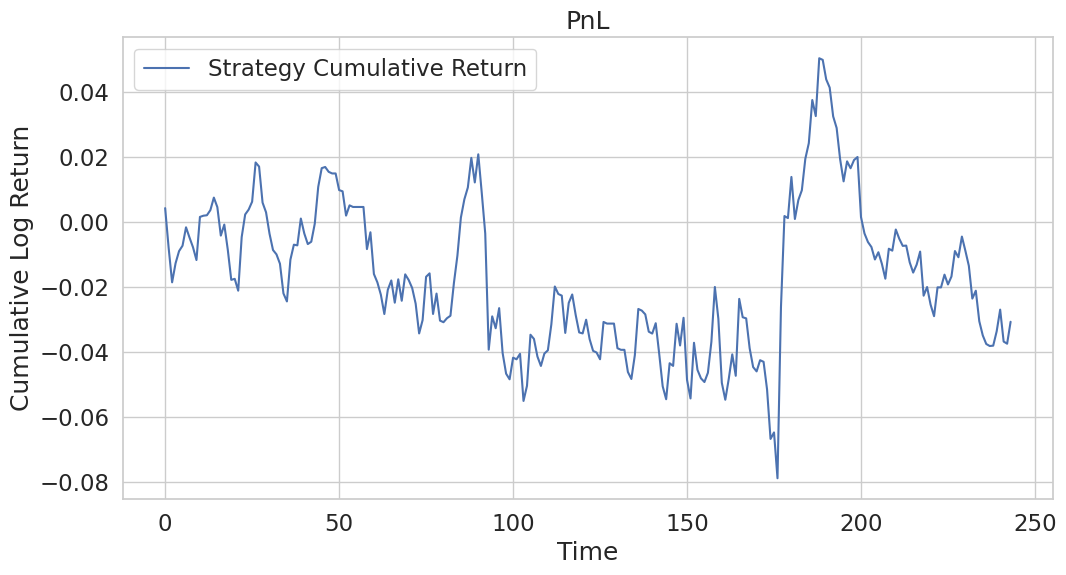

In [95]:
# Plot the cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(my_strategy['Cumulative Return'], label="Strategy Cumulative Return")
plt.title("PnL")
plt.xlabel("Time")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.show()

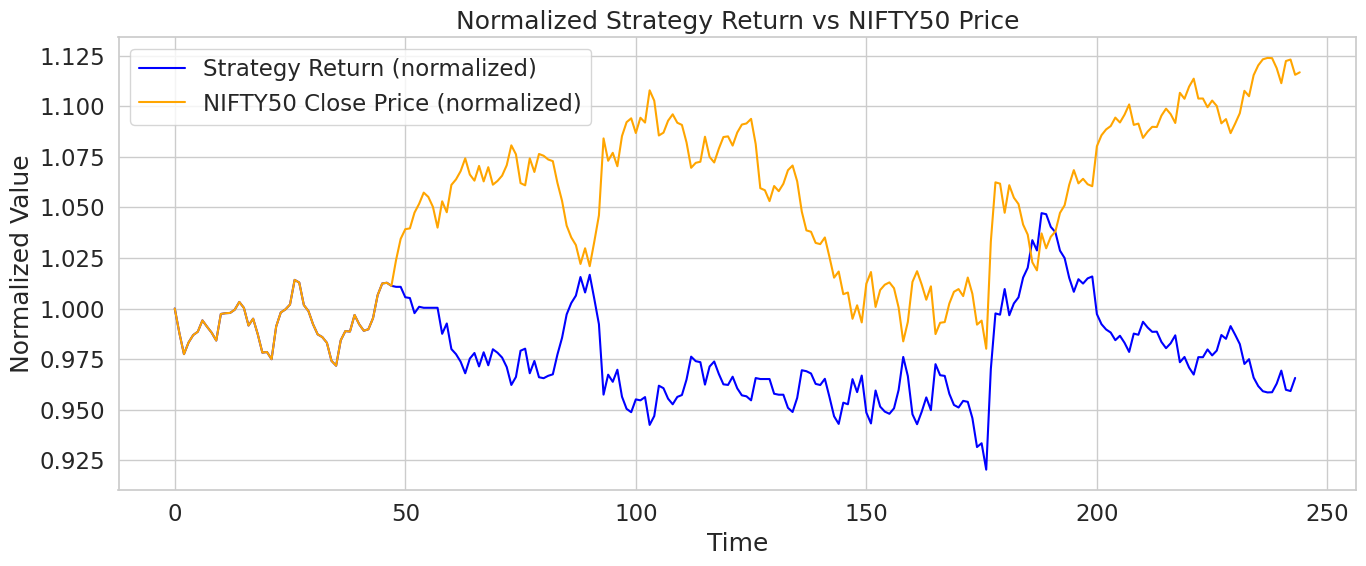

In [96]:
# Convert cumulative log return to cumulative return
cumulative_return_pct = np.exp(my_strategy['Cumulative Return'])

# Normalize both to start at 1
cumulative_return_norm = cumulative_return_pct / cumulative_return_pct[0]

plt.figure(figsize=(14, 6))
plt.plot(cumulative_return_norm, label="Strategy Return (normalized)", color='blue')
plt.plot(close_price_norm, label="NIFTY50 Close Price (normalized)", color='orange')
plt.title("Normalized Strategy Return vs NIFTY50 Price")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [97]:
simple_returns = np.exp(my_strategy['Strategy Return']) - 1
metrics = strategy_metrics(simple_returns,periods_per_year=252,risk_free_rate=0.0)

print("Annualized Return: ", f"{metrics['Annualized Return']*100:.2f}%")
print("Sharpe Ratio:       ", f"{metrics['Sharpe Ratio']:.2f}")
print("Max Drawdown:       ", f"{metrics['Max Drawdown']*100:.2f}%")
print("Sortino Ratio:      ", f"{metrics['Sortino Ratio']:.2f}")

Annualized Return:  -3.12%
Sharpe Ratio:        -0.16
Max Drawdown:        9.49%
Sortino Ratio:       -0.28


# Trading Strategy 3

In [98]:
def volatility_scaled_strategy(
    pred_ret_np,
    true_ret_np,
    type_pred,
    rolling_window = 10,
    scale = 1.0,
    max_leverage = 1.0,
    transaction_cost=0.0005
):

    # Convert into pd.Series object
    pred_ret = pd.Series(pred_ret_np, name="predicted returns")
    true_ret = pd.Series(true_ret_np, name="actual returns")

    # Calculate rolling volatility (sift to avoid look-ahead)
    rolling_vol = true_ret.rolling(rolling_window).std().shift(1)

    # Calculate position size
    position = scale * pred_ret / (rolling_vol + 1e-8)
    position = position.clip(-max_leverage, max_leverage)

    if type_pred == "close_open":
      # Costs (considering the first rolling_window are NANS, no position change here)

      # Pay transaction cost considering at night I am out of the market
      prev_pos_nz = positions[:-1] != 0
      curr_pos_nz = positions[1:] != 0
      costs = np.zeros_like(positions, dtype=float)
      costs[1:] = transaction_cost * (prev_pos_nz.astype(int) + curr_pos_nz.astype(int))

      # Pay also at start
      costs[0] = transaction_cost * (positions[0] != 0).astype(int)
    else:
      pos_change = np.diff(positions, prepend=0)
      costs = np.abs(pos_change).astype(float) * transaction_cost


    # Compute strategy returns
    strategy_returns = position * true_ret - costs
    cumulative_returns = strategy_returns.cumsum()
    equity_curve = np.exp(cumulative_returns)

    results = pd.DataFrame({
        "Predicted Return": pred_ret,
        "Strategy Return": strategy_returns,
        "Equity Curve": equity_curve
    })

    return results


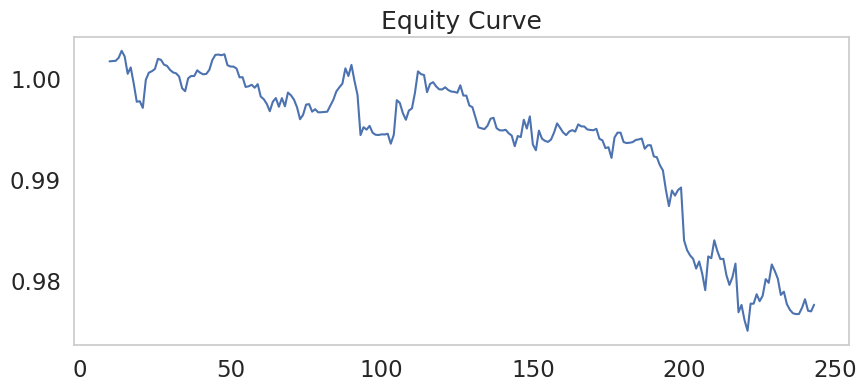

In [99]:
strategy_results = volatility_scaled_strategy(pred_flat, true_flat, "close_close")
# strategy_results = volatility_scaled_strategy(pred_flat, true_flat, "close_open")


strategy_results["Equity Curve"].plot(title="Equity Curve", figsize=(10, 4))
plt.grid()
plt.show()

In [100]:
strategy_results['Equity Curve'].fillna(1, inplace=True)

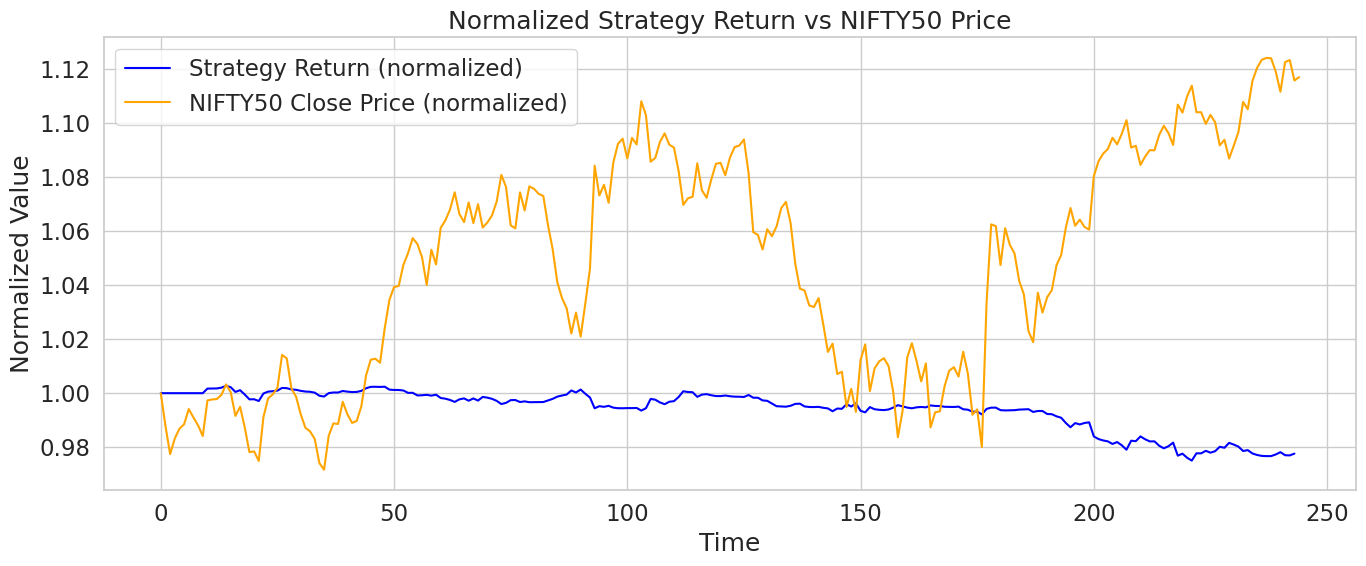

In [101]:
# Normalize both to start at 1
cumulative_return_norm = strategy_results['Equity Curve'] / strategy_results['Equity Curve'].iloc[0]

plt.figure(figsize=(14, 6))
plt.plot(cumulative_return_norm, label="Strategy Return (normalized)", color='blue')
plt.plot(close_price_norm, label="NIFTY50 Close Price (normalized)", color='orange')
plt.title("Normalized Strategy Return vs NIFTY50 Price")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [102]:
simple_returns = np.exp(strategy_results["Strategy Return"].dropna()) - 1

metrics = strategy_metrics(simple_returns,periods_per_year=252,risk_free_rate=0.0)

print("Annualized Return: ", f"{metrics['Annualized Return']*100:.2f}%")
print("Sharpe Ratio:       ", f"{metrics['Sharpe Ratio']:.2f}")
print("Max Drawdown:       ", f"{metrics['Max Drawdown']*100:.2f}%")
print("Sortino Ratio:      ", f"{metrics['Sortino Ratio']:.2f}")

Annualized Return:  -2.41%
Sharpe Ratio:        -1.46
Max Drawdown:        2.76%
Sortino Ratio:       -1.87


# Addition of SP500 data
(the rest is the same)

In [104]:
# Load Nifty50 and SPY data

SPY_path = '/content/drive/MyDrive/EconometricsLSTM/common_daily_SPY_filtered_lag_tech_ind.csv'
NIFTY_path = '/content/drive/MyDrive/EconometricsLSTM/common_daily_nifty_filtered_lag_tech_ind.csv'

nifty = pd.read_csv(NIFTY_path, parse_dates=['Date'])
spy   = pd.read_csv(SPY_path, parse_dates=['Date'])

# Rename SPY OHLCV columns for merging
spy = spy[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(
    columns={
        'Open': 'Open_SPY',
        'High': 'High_SPY',
        'Low': 'Low_SPY',
        'Close': 'Close_SPY',
        'Volume': 'Volume_SPY'
    }
)

spy['Log_return_SPY'] = np.log(spy['Close_SPY']/spy['Open_SPY'])

nifty['target'] =  np.log(nifty['close']/nifty['Close'])
# nifty['target'] =  np.log(nifty['close']/nifty['open'])
nifty['Nifty_Log_return'] = nifty['target'].shift(1)

# Merge on Date, keep only dates present in both
df = pd.merge(nifty, spy, on='Date', how='inner')

print(df.head())



   Unnamed: 0  X.1  X       Date     open     high  low    close     volume  \
0           1    3  3 2017-01-04  8200.80  8218.45    1  8196.35  141064842   
1           2    4  4 2017-01-05  8226.65  8282.55    1  8270.50  166577106   
2           3    5  5 2017-01-06  8283.00  8306.50    1  8248.20  150211914   
3           4    6  6 2017-01-09  8259.10  8260.30    1  8234.55  106756707   
4           5    7  7 2017-01-10  8262.70  8293.55    1  8290.30  159650303   

      Open  ...        obv  wr    target  Nifty_Log_return  Open_SPY  \
0  8195.25  ...  253479441 NaN  0.000891               NaN    225.04   
1  8200.80  ...  394544283 NaN  0.009006          0.000891    225.62   
2  8226.65  ...  561121389 NaN -0.002700          0.009006    226.27   
3  8283.00  ...  410909475 NaN -0.001656         -0.002700    226.53   
4  8259.10  ...  304152768 NaN  0.006747         -0.001656    226.91   

   High_SPY  Low_SPY  Close_SPY  Volume_SPY  Log_return_SPY  
0    225.83   223.88     225.2

In [105]:
# Select the features and target

FEATURES = ['Nifty_Log_return', 'Log_return_SPY', 'Volume', 'Volume_SPY', 'macd','rsi','ulti','volatility','roc','dema','atr','cci',
            'obv','wr']
TARGET   = 'target'

# Restrict the dataframe from the dates with no NaNs
df = df[df['Date'] >= '2017-02-14'].reset_index(drop=True)

# Keep test all 2019, train from start to end sept 2018, val last 3 months of 2019
train_end   = pd.to_datetime('2018-09-30')
val_start   = pd.to_datetime('2018-10-01')
val_end     = pd.to_datetime('2018-12-31')
test_start  = pd.to_datetime('2019-01-01')

# Hyperparameters for bulding the dataset (telescope, i.e. the len of the prediction
# output is set to 1: we focus on the single point 1-step ahead predction. Also
# stride is set to 1 so that the window moves one-at-a-time)
WINDOW    = 10
STRIDE    = 1
TELESCOPE = 1  # one-day ahead

# For each split, extend backwards by WINDOW days to allow full sequences (so we can alow full
# 2019 prediction, or validation on all last three months of 2018)
# The final +1 is given for purposes seen in the following loop
train_end_idx = df.index[df['Date'] <= train_end].max()+1
val_start_idx = df.index[df['Date'] >= val_start].min()+1
val_end_idx = df.index[df['Date'] <= val_end].max()+1
test_start_idx= df.index[df['Date'] >= test_start].min()+1

# Extend each split backwards by WINDOW rows
raw_train = df.iloc[: train_end_idx + 1]  # all rows up to train_end (INCLUDED)
raw_val   = df.iloc[ max(0, val_start_idx - WINDOW) : val_end_idx + 1 ]
raw_test  = df.iloc[ max(0, test_start_idx - WINDOW) : ]

print("Train slice rows:", raw_train.shape)
print("Val   slice rows:", raw_val.shape)
print("Test  slice rows:", raw_test.shape)

# Separate X/y
Xtr_df, ytr_df = raw_train[FEATURES], raw_train[[TARGET]]
Xvl_df, yvl_df = raw_val[FEATURES],   raw_val[[TARGET]]
Xte_df, yte_df = raw_test[FEATURES],  raw_test[[TARGET]]

# Min–Max scaling
x_scaler = MinMaxScaler().fit(Xtr_df)
Xtr = x_scaler.transform(Xtr_df)
Xvl = x_scaler.transform(Xvl_df)
Xte = x_scaler.transform(Xte_df)

y_scaler = MinMaxScaler().fit(ytr_df)
ytr = y_scaler.transform(ytr_df)
yvl = y_scaler.transform(yvl_df)
yte = y_scaler.transform(yte_df)

Xtr, ytr, dtr = build_sequences(Xtr, ytr, raw_train['Date'].values, window = WINDOW, telescope=TELESCOPE, stride= STRIDE)
Xvl, yvl, dvl = build_sequences(Xvl, yvl, raw_val  ['Date'].values, window = WINDOW, telescope=TELESCOPE, stride= STRIDE)
Xte, yte, dte = build_sequences(Xte, yte, raw_test ['Date'].values, window = WINDOW, telescope=TELESCOPE, stride= STRIDE)

print("Train preds:", len(dtr),
      "Val preds:", len(dvl),
      "Test preds:", len(dte))

Train slice rows: (392, 32)
Val   slice rows: (68, 32)
Test  slice rows: (247, 32)
Train preds: 382 Val preds: 58 Test preds: 237


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 10, 14)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 10, 128)        │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 10, 1)          │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_10 (Cropping1D)      │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,329 (1.66 MB)

 Trainable params: 435,329 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 - 4s - 183ms/step - loss: 0.0811 - val_loss: 0.0695 - learning_rate: 1.0000e-03
Epoch 2/200
24/24 - 0s - 13ms/step - loss: 0.0294 - val_loss: 0.0629 - learning_rate: 1.0000e-03
Epoch 3/200
24/24 - 0s - 12ms/step - loss: 0.0244 - val_loss: 0.0635 - learning_rate: 1.0000e-03
Epoch 4/200
24/24 - 0s - 15ms/step - loss: 0.0254 - val_loss: 0.0632 - learning_rate: 1.0000e-03
Epoch 5/200
24/24 - 1s - 24ms/step - loss: 0.0265 - val_loss: 0.0648 - learning_rate: 1.0000e-03
Epoch 6/200
24/24 - 0s - 15ms/step - loss: 0.0243 - val_loss: 0.0616 - learning_rate: 1.0000e-03
Epoch 7/200
24/24 - 0s - 12ms/step - loss: 0.0259 - val_loss: 0.0614 - learning_rate: 1.0000e-03
Epoch 8/200
24/24 - 0s - 13ms/step - loss: 0.0245 - val_loss: 0.0613 - learning_rate: 1.0000e-03
Epoch 9/200
24/24 - 1s - 26ms/step - loss: 0.0241 - val_loss: 0.0614 - learning_rate: 1.0000e-03
Epoch 10/200
24/24 - 0s - 15ms/step - loss: 0.0221 - val_loss: 0.0612 - learning_rate: 1.0000e-03
Epoch 11/200
24/24 - 0s - 13

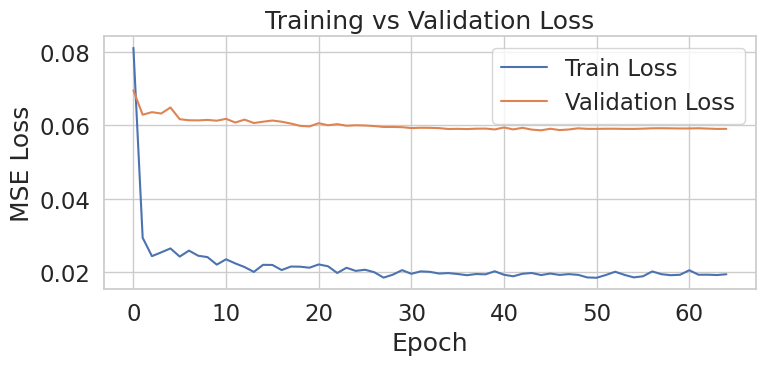

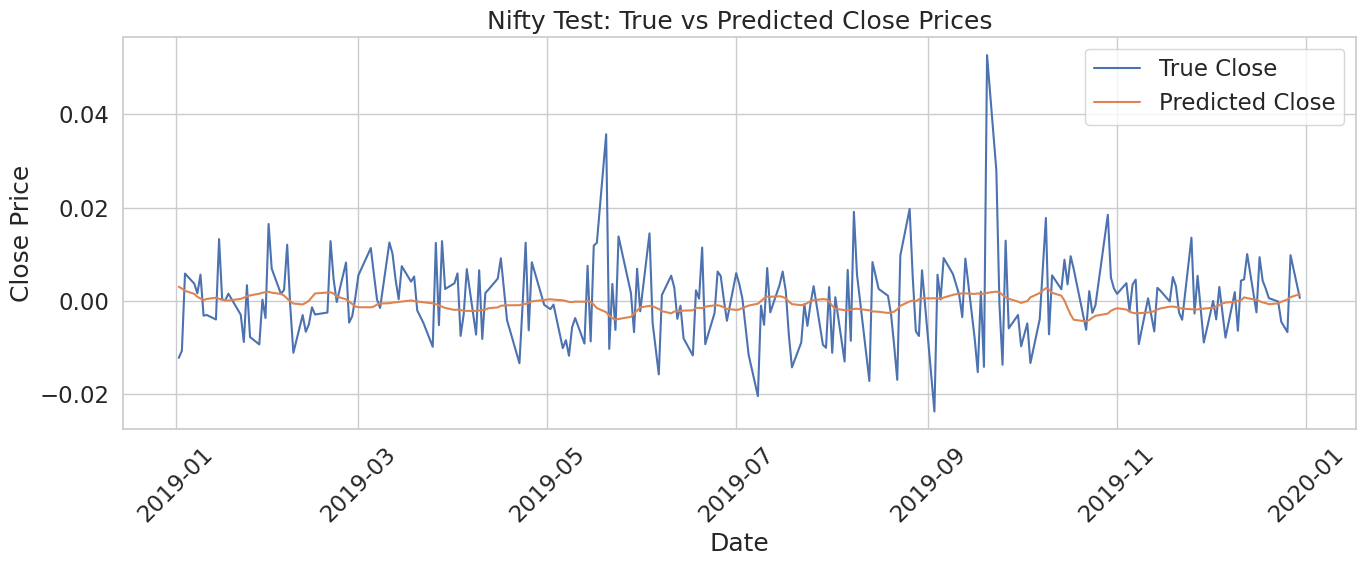

In [106]:
model = build_conv_lstm((WINDOW, len(FEATURES)), TELESCOPE)
model.summary()

# Train once on train+val
es = callbacks.EarlyStopping('val_loss', patience=20, restore_best_weights=True)
rl = callbacks.ReduceLROnPlateau('val_loss', patience=5, factor=0.1, min_lr=1e-5)

history = model.fit(
    Xtr, ytr,
    validation_data=(Xvl, yvl),
    epochs=200, batch_size=16,
    callbacks=[es, rl],
    verbose=2
)


# Evaluate on test
pred = model.predict(Xte).reshape(-1,)
true = yte.reshape(-1,)
# Inverse scale
pred_flat_SP500 = y_scaler.inverse_transform(pred.reshape(-1,1)).flatten()
true_flat_SP500 = y_scaler.inverse_transform(true.reshape(-1,1)).flatten()

print(f"Test MSE: {mean_squared_error(true_flat_SP500, pred_flat_SP500):.4f}")
print(f"Test MAE: {mean_absolute_error(true_flat_SP500, pred_flat_SP500):.4f}")

# Directional accuracy
directional_acc = np.mean((pred_flat_SP500 > 0) == (true_flat_SP500  > 0))
print(f"Directional Accuracy: {100 * directional_acc:.2f}%")

# Plot training & validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ALL test predictions vs true with dates
results = pd.DataFrame({'Date': dte, 'True_Close': true_flat_SP500, 'Pred_Close': pred_flat_SP500})
results.set_index('Date', inplace=True)
plt.figure(figsize=(14,6))
plt.plot(results.index, results['True_Close'], label='True Close')
plt.plot(results.index, results['Pred_Close'], label='Predicted Close')
plt.xticks(rotation=45); plt.xlabel('Date'); plt.ylabel('Close Price')
plt.title('Nifty Test: True vs Predicted Close Prices')
plt.legend(); plt.tight_layout(); plt.show()


# Trading strategy 2

In [107]:
my_strategy_SP500 = trading_strategy(pred_flat_SP500, true_flat_SP500,"close_close",  0.0005, 0.0001)
#my_strategy_SP500 = trading_strategy(pred_flat_SP500, true_flat_SP500,"close_open",  0.0005, 0.0001)

print(my_strategy_SP500.head())

   Position  Strategy Return  Cumulative Return   Costs
0         1        -0.012673          -0.012673  0.0005
1         1        -0.010648          -0.023321  0.0000
2         1         0.005888          -0.017433  0.0000
3         1         0.003716          -0.013717  0.0000
4         1         0.001665          -0.012052  0.0000


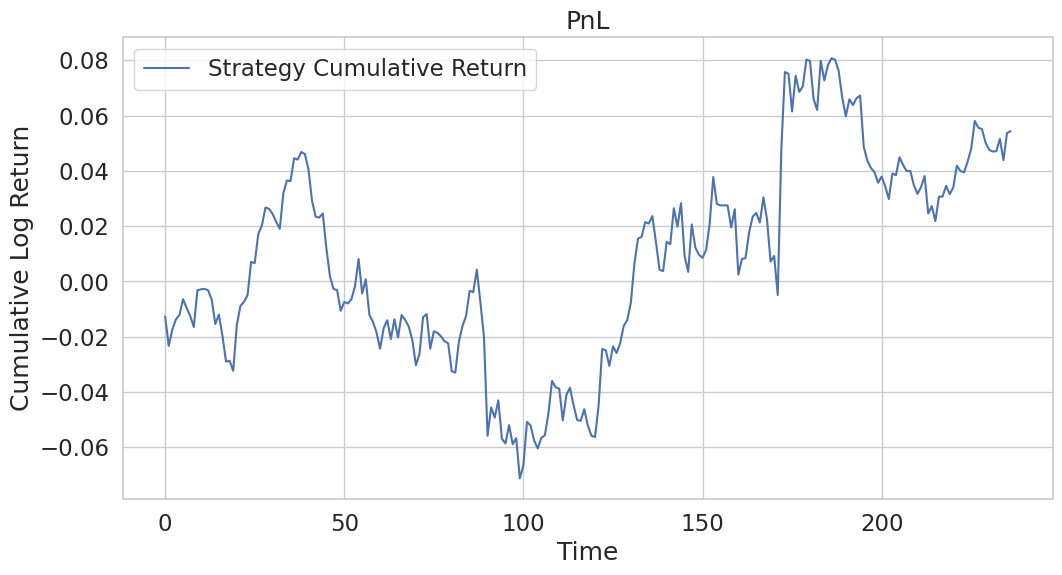

In [108]:
# Plot the cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(my_strategy_SP500['Cumulative Return'], label="Strategy Cumulative Return")
plt.title("PnL")
plt.xlabel("Time")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.show()

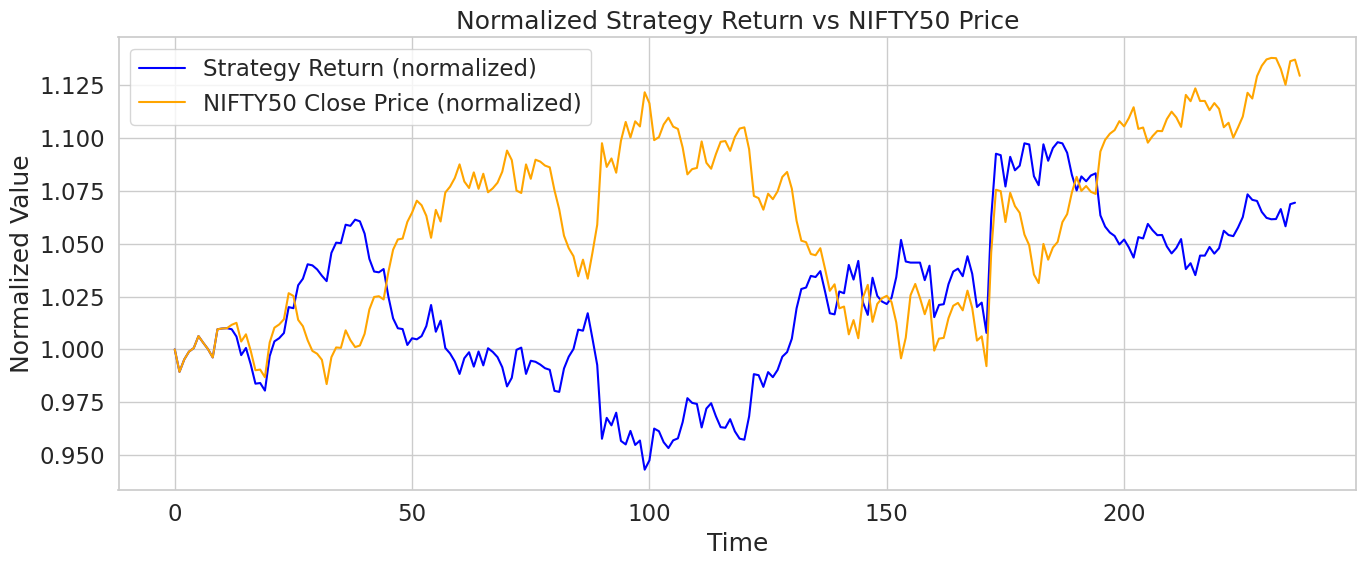

In [109]:
# Convert cumulative log return to cumulative return
cumulative_return_pct_SP500 = np.exp(my_strategy_SP500['Cumulative Return'])

# Normalize both to start at 1
cumulative_return_norm_SP500 = cumulative_return_pct_SP500 / cumulative_return_pct_SP500[0]
df_2019 = df[df['Date'] >= '2019-01-01'].reset_index()
close_price_norm_SP500 = df_2019['close'] / df_2019['close'].iloc[0]

plt.figure(figsize=(14, 6))
plt.plot(cumulative_return_norm_SP500, label="Strategy Return (normalized)", color='blue')
plt.plot(close_price_norm_SP500, label="NIFTY50 Close Price (normalized)", color='orange')
plt.title("Normalized Strategy Return vs NIFTY50 Price")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [110]:
simple_returns_SP500 = np.exp(my_strategy_SP500["Strategy Return"].dropna()) - 1

metrics = strategy_metrics(simple_returns_SP500,periods_per_year=252,risk_free_rate=0.0)

print("Annualized Return: ", f"{metrics['Annualized Return']*100:.2f}%")
print("Sharpe Ratio:       ", f"{metrics['Sharpe Ratio']:.2f}")
print("Max Drawdown:       ", f"{metrics['Max Drawdown']*100:.2f}%")
print("Sortino Ratio:      ", f"{metrics['Sortino Ratio']:.2f}")

Annualized Return:  5.95%
Sharpe Ratio:        0.49
Max Drawdown:        11.13%
Sortino Ratio:       0.78
